### <span style='color:blue '> Projet 6: Classifiez automatiquement des biens de consommation </span>

- Consignes : https://openclassrooms.com/fr/projects/631/assignment
- Données : https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/Parcours_data_scientist/Projet+-+Textimage+DAS+V2/Dataset+projet+pre%CC%81traitement+textes+images.zip

#### Etude de faisabilité du moteur de classification

- #### Mission : 
Réaliser une première étude de faisabilité d'un moteur de classification d'articles basé sur une image et une description pour l'automatisation de l'attribution de la catégorie de l'article.
- #### Contraintes
Mettre en œuvre un algorithme de type SIFT / ORB / SURF

#### Chargement des librairies

In [4]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import cv2 as cv
from glob import glob
import os
sns.set_style('dark')

In [5]:
import nltk

In [6]:
from string import punctuation
from nltk.corpus import stopwords
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
from nltk import word_tokenize

In [7]:
from yellowbrick.text import TSNEVisualizer
from sklearn import manifold

#### Installation des Modules nécessaires

In [5]:
# pip install yellowbrick
# conda install -c https://conda.anaconda.org/conda-forge wordcloud
# pip install wordcloud
# pip install opencv-python==4.5.3.56

In [3]:
# pip install tensorflow
# pip install imutils

#### Chargement des données

In [9]:
# Définir le répertoire de travail actuel 
os.chdir(r'C:\Users\sahel\OneDrive\Documents\DataScientest\Projet 6\data\Flipkart')

In [10]:
df = pd.read_csv('flipkart_com-ecommerce_sample_1050.csv')

### <span style='color:blue '>1. Description des données </span>

In [11]:
df.head(2).T

0  \
uniq_id                                   55b85ea15a1536d46b7190ad6fff8ce7   
crawl_timestamp                                  2016-04-30 03:22:56 +0000   
product_url              http://www.flipkart.com/elegance-polyester-mul...   
product_name             Elegance Polyester Multicolor Abstract Eyelet ...   
product_category_tree    ["Home Furnishing >> Curtains & Accessories >>...   
pid                                                       CRNEG7BKMFFYHQ8Z   
retail_price                                                        1899.0   
discounted_price                                                     899.0   
image                                 55b85ea15a1536d46b7190ad6fff8ce7.jpg   
is_FK_Advantage_product                                              False   
description              Key Features of Elegance Polyester Multicolor ...   
product_rating                                         No rating available   
overall_rating                                         No rating available   
brand                                                             Elegance   
product_specifications   {"product_specification"=>[{"key"=>"Brand", "v...   

                                                                         1  
uniq_id                                   7b72c92c2f6c40268628ec5f14c6d590  
crawl_timestamp                                  2016-04-30 03:22:56 +0000  
product_url              http://www.flipkart.com/sathiyas-cotton-bath-t...  
product_name                                    Sathiyas Cotton Bath Towel  
product_category_tree    ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  
pid                                                       BTWEGFZHGBXPHZUH  
retail_price                                                         600.0  
discounted_price                                                     449.0  
image                                 7b72c92c2f6c40268628ec5f14c6d590.jpg  
is_FK_Advantage_product                                              False  
description              Specifications of Sathiyas Cotton Bath Towel (...  
product_rating                                         No rating available  
overall_rating                                         No rating available  
brand                                                             Sathiyas  
product_specifications   {"product_specification"=>[{"key"=>"Machine Wa...

##### Les données représentent 1050 images.Chaque ligne correspond à une image, avec son nom et ses caractéristiques associées telle qu'une description, la catégorie du produit etc...

### <span style='color:red'>1.1.Structure des données </span>

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 12  overall_rating           1050 non-null   object 
 13  brand                    712 non-null    object 
 14  product_specifications  

In [13]:
# Exemple de l'arborescence de catégories des produits
df['product_category_tree'].loc[1]

'["Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Sathiyas Baby Bath Towels >> Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Y..."]'

In [14]:
# Exemple de spécification d'un produit
df['product_specifications'].loc[1]

'{"product_specification"=>[{"key"=>"Machine Washable", "value"=>"Yes"}, {"key"=>"Material", "value"=>"Cotton"}, {"key"=>"Design", "value"=>"Self Design"}, {"key"=>"Brand", "value"=>"Sathiyas"}, {"key"=>"Type", "value"=>"Bath Towel"}, {"key"=>"GSM", "value"=>"500"}, {"key"=>"Model Name", "value"=>"Sathiyas cotton bath towel"}, {"key"=>"Ideal For", "value"=>"Men, Women, Boys, Girls"}, {"key"=>"Model ID", "value"=>"asvtwl322"}, {"key"=>"Color", "value"=>"Red, Yellow, Blue"}, {"key"=>"Size", "value"=>"Mediam"}, {"key"=>"Length", "value"=>"30 inch"}, {"key"=>"Width", "value"=>"60 inch"}, {"key"=>"Number of Contents in Sales Package", "value"=>"3"}, {"key"=>"Sales Package", "value"=>"3 Bath Towel"}]}'

In [15]:
# Exemple de la description d'un produit
df['description'].loc[1]

'Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yellow, Blue) Bath Towel Features Machine Washable Yes Material Cotton Design Self Design General Brand Sathiyas Type Bath Towel GSM 500 Model Name Sathiyas cotton bath towel Ideal For Men, Women, Boys, Girls Model ID asvtwl322 Color Red, Yellow, Blue Size Mediam Dimensions Length 30 inch Width 60 inch In the Box Number of Contents in Sales Package 3 Sales Package 3 Bath Towel'

### Représentation les mots les plus fréquents par le WordClouds (nuages de mots-clés)

Les WordClouds (nuages de mots-clés en français) sont des outils utiles pour synthétiser les notions les plus importantes d’un texte.

Regardons les mots les plus fréquents dans les descriptions et les noms des produits. 

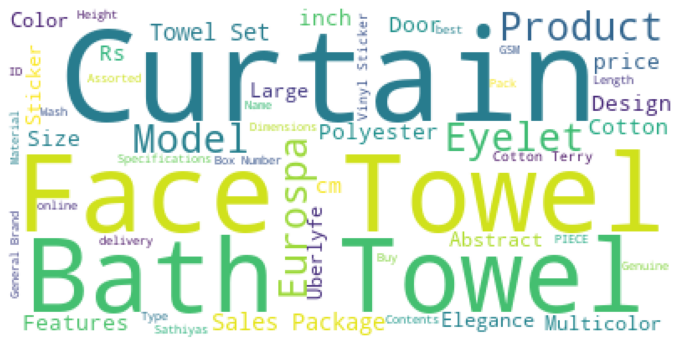

In [16]:
from wordcloud import WordCloud, STOPWORDS

text = df['description'].values 
wordcloud = WordCloud(background_color = "white", max_words = 50).generate(str(text))

plt.figure(figsize=(12,12))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

Les mots les plus présents dans la description des produits sont «Towel, Bath, face, Curtain»             

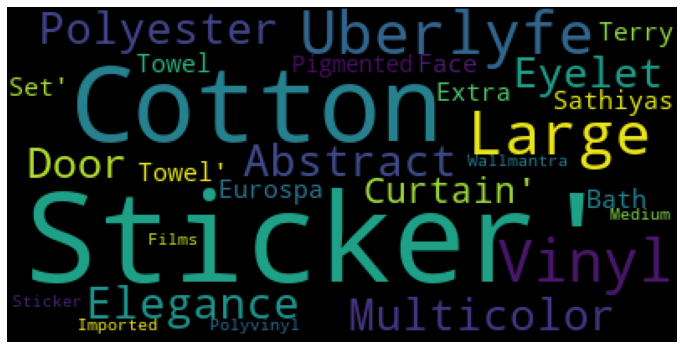

In [17]:
texte = df['product_name'].values 
wordcloud = WordCloud().generate(str(texte))

plt.figure(figsize=(12,12))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

Pour le nom des produit, les mots les plus présents sont presque les mêmes mots que dans la description.   

### <span style='color:red'>1.2.Données manquantes </span>

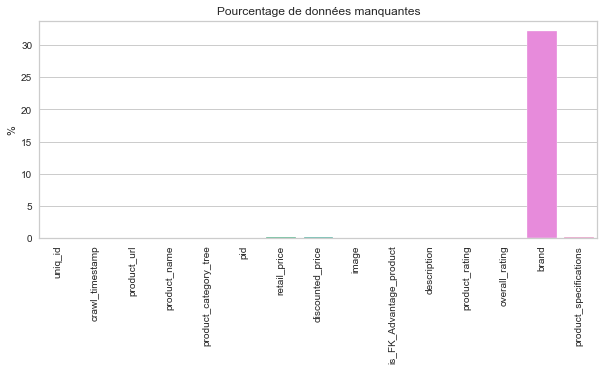

In [18]:
# Calcul du nombre de valeurs manquantes par colonne
df_na = df.isna().sum()/len(df)*100
# Affichage graphique
fig = plt.figure(1, figsize=(10, 4))
sns.barplot(x=df_na.index, y=df_na.values)
plt.xticks(rotation=90)
plt.xlabel("")
plt.ylabel("%")
plt.title("Pourcentage de données manquantes")
plt.show()

### <span style='color:purple'>1.2.1.Imputation des valeures manquantes </span>

La feature 'brand' contient plus de 30 % de données manquantes. Les valeurs manquantes de cette variable sont remplacées par "  ".

In [19]:
# Imputation des valeures manquantes de "brand" par " "
df['brand'] = df['brand'].fillna('')

In [20]:
df['brand'].value_counts().sort_values(ascending = False)

                 338
PRINT SHAPES      11
Lapguard          11
Lal Haveli        10
Raymond            8
                ... 
Relaxfeel          1
Bhalaria           1
MSenterprises      1
Nutcase            1
Mee Mee            1
Name: brand, Length: 491, dtype: int64

### <span style='color:purple'>1.2.2.Suppression des colonnes inutiles </span>

In [21]:
df = df.drop(columns=[
    'crawl_timestamp',
    'product_url',
    'pid',
    'retail_price',
    'discounted_price',
    'is_FK_Advantage_product',
    'product_rating',
    'overall_rating',
    'product_specifications',
])

df.head(3).T

0  \
uniq_id                                 55b85ea15a1536d46b7190ad6fff8ce7   
product_name           Elegance Polyester Multicolor Abstract Eyelet ...   
product_category_tree  ["Home Furnishing >> Curtains & Accessories >>...   
image                               55b85ea15a1536d46b7190ad6fff8ce7.jpg   
description            Key Features of Elegance Polyester Multicolor ...   
brand                                                           Elegance   

                                                                       1  \
uniq_id                                 7b72c92c2f6c40268628ec5f14c6d590   
product_name                                  Sathiyas Cotton Bath Towel   
product_category_tree  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...   
image                               7b72c92c2f6c40268628ec5f14c6d590.jpg   
description            Specifications of Sathiyas Cotton Bath Towel (...   
brand                                                           Sathiyas   

                                                                       2  
uniq_id                                 64d5d4a258243731dc7bbb1eef49ad74  
product_name                         Eurospa Cotton Terry Face Towel Set  
product_category_tree  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  
image                               64d5d4a258243731dc7bbb1eef49ad74.jpg  
description            Key Features of Eurospa Cotton Terry Face Towe...  
brand                                                            Eurospa

In [22]:
100*(df.isna().sum()/df.shape[0]).sort_values(ascending=True)

uniq_id                  0.0
product_name             0.0
product_category_tree    0.0
image                    0.0
description              0.0
brand                    0.0
dtype: float64

### <span style='color:red'> 1.3.Étude des catégories de produits </span>


##### Chaque image est catégorisée par un système d'arbres avec plusieurs profondeurs. Le nom de la colonne renseignant des catégories est 'product_category_tree'

In [23]:
df.groupby('product_category_tree').count()['uniq_id'].sort_values(ascending=False)

product_category_tree
["Home Furnishing >> Bed Linen >> Blankets, Quilts & Dohars"]                                                                                          56
["Kitchen & Dining >> Coffee Mugs >> Prithish Coffee Mugs"]                                                                                            26
["Watches >> Wrist Watches >> Maxima Wrist Watches"]                                                                                                   23
["Kitchen & Dining >> Coffee Mugs >> Rockmantra Coffee Mugs"]                                                                                          22
["Watches >> Wrist Watches >> Sonata Wrist Watches"]                                                                                                   19
                                                                                                                                                       ..
["Beauty and Personal Care >> Makeup >> Nails >> Nail 

##### Nous récupérons la colonne "product_category_tree", et nous créeront d'une nouvelle série catégorie en 3 profondeurs. 

In [24]:
def split_categories(category, level):
    '''Fonction qui affiche les '''
    category = category.split('["')[1].split('"]')[0]
    cat = category.split(' >> ')
    if(len(cat)) < 3:
        cat = [cat[0], cat[1], 'None']
        if(len(cat))<2:
            cat = [cat[0], 'None', 'None']
    return cat[level]

def split_categories_1(category):
    return split_categories(category,0)
def split_categories_2(category):
    return split_categories(category,1)
def split_categories_3(category):
    return split_categories(category,2)

def detail_categories(dataframe):
    dataframe['cat_1'] = dataframe['product_category_tree'].apply(split_categories_1)
    dataframe['cat_2'] = dataframe['product_category_tree'].apply(split_categories_2)
    dataframe['cat_3'] = dataframe['product_category_tree'].apply(split_categories_3)
    return dataframe.drop(['product_category_tree'], axis=1)

In [25]:
df = detail_categories(df)

In [26]:
df.sample(3)

uniq_id  \
597  30ab693b54e99a469a1152b5db14aa40   
920  e87bad0de3447c9ac3a8555e89545c75   
740  fd53c8ed19e77c3e65d767e6aee5fad7   

                                          product_name  \
597     LITTLE FEETZ Baby Girl's Solid Top & Skirt Set   
920            Baby Bucket Cartoon Single Blanket blue   
740  Pindia Apple Macbook Pro 13 13.3 Inch Mb990hn/...   

                                    image  \
597  30ab693b54e99a469a1152b5db14aa40.jpg   
920  e87bad0de3447c9ac3a8555e89545c75.jpg   
740  fd53c8ed19e77c3e65d767e6aee5fad7.jpg   

                                           description         brand  \
597  Key Features of LITTLE FEETZ Baby Girl's Solid...  LITTLE FEETZ   
920  Buy Baby Bucket Cartoon Single Blanket blue at...   Baby Bucket   
740  Buy Pindia Apple Macbook Pro 13 13.3 Inch Mb99...        Pindia   

               cat_1               cat_2                      cat_3  
597        Baby Care         Infant Wear        Baby Girls' Clothes  
920  Home Furnishing           Bed Linen  Blankets, Quilts & Dohars  
740        Computers  Laptop Accessories            Anti Dust Plugs

Nous allons : 
- 7 catégories dans la profondeur 1
- 62 catégories dans la profondeur 2
- 242 catégories dans la profondeur 3

Regardons la distribution de catégorie de produit dans chacune de ces profondeurs 

#### <span style='color:purple'> 1.3.1.Distribution de catégorie de produit au 1e niveau </span>

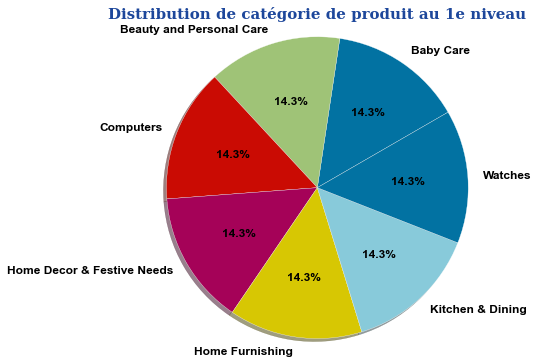

In [27]:
cat_1 = df.groupby(by='cat_1')['uniq_id'].nunique()

font_title = {'family': 'serif',
              'color':  '#1d479b',
              'weight': 'bold',
              'size': 15,
             }

fig, ax = plt.subplots(figsize=(6,6))
ax.pie(cat_1.values, labels=cat_1.index, 
       autopct='%1.1f%%', shadow=True, startangle=30,
       textprops=dict(color="black",size=12, weight="bold"))
ax.axis('equal')
ax.set_title("Distribution de catégorie de produit au 1e niveau", fontdict=font_title)
plt.show()

In [28]:
df_image_par_cat = df.groupby('cat_1').agg({'image' : 'count'})
df_image_par_cat

image
cat_1                            
Baby Care                     150
Beauty and Personal Care      150
Computers                     150
Home Decor & Festive Needs    150
Home Furnishing               150
Kitchen & Dining              150
Watches                       150

Il y a 150 images par catégorie de première profondeur

#### WordClouds (nuages de mots-clés) pour 1e niveau

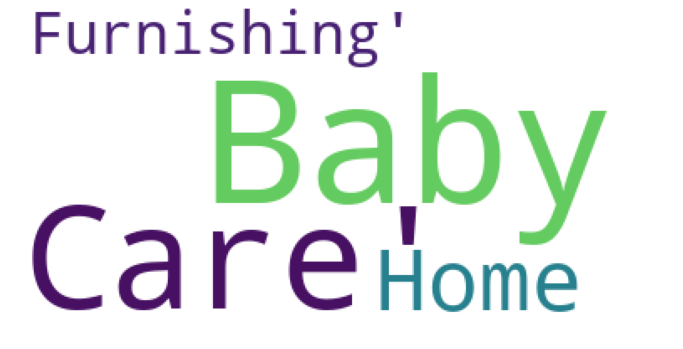

In [29]:
text = df['cat_1'].values 
wordcloud = WordCloud(background_color = "white").generate(str(text))

plt.figure(figsize=(12,12))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

#### <span style='color:purple'> 1.3.2.Distribution de catégorie de produit au 2e niveau </span>

C:\Users\sahel\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


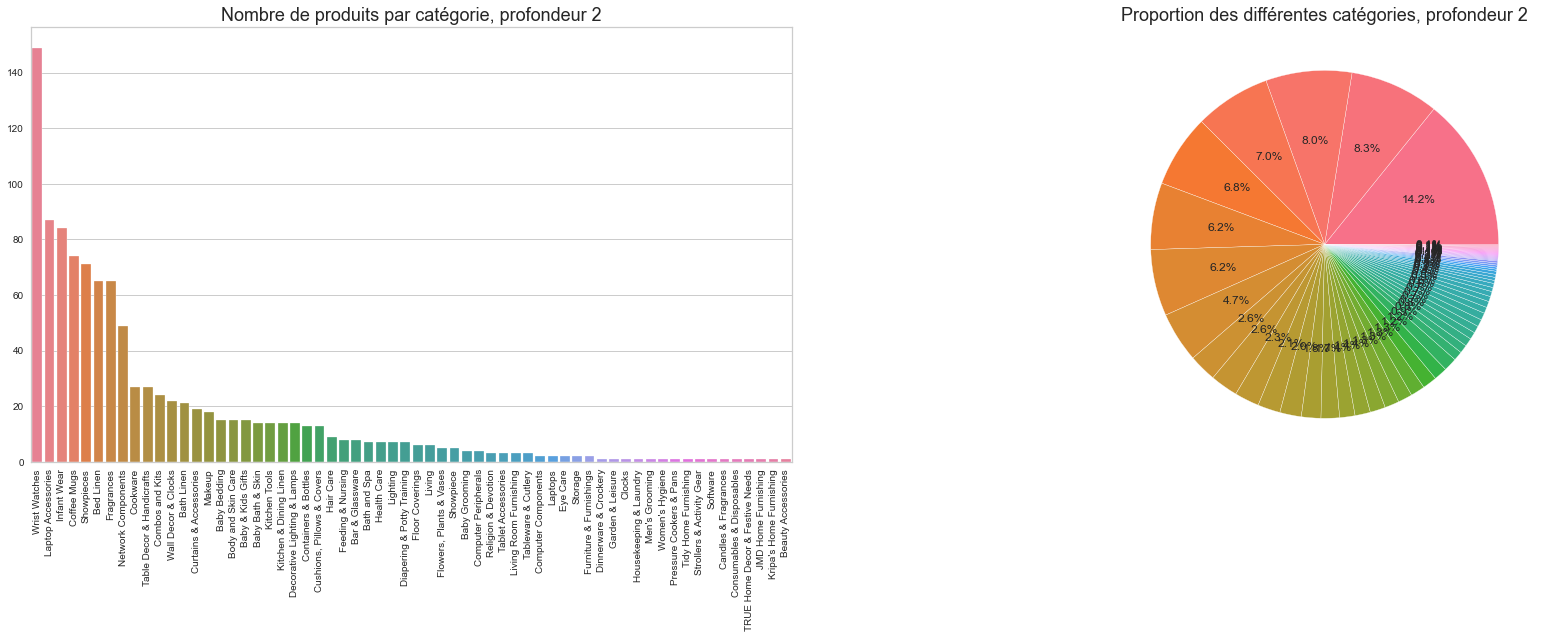

In [30]:
# Histogramme et Pieplot de la répartition des catégories dans la profondeur 2
fig = plt.figure(1, figsize=(30, 8))
categories_2 = df["cat_2"].value_counts()

plt.title("Proportion des différentes catégories")

sns.set_palette(sns.color_palette("husl", len(categories_2)))

# Barplot 
plt.subplot(1, 2, 1)
plt.title("Nombre de produits par catégorie, profondeur 2", fontsize=18)

sns.barplot(categories_2.index, categories_2.values, orient="v")
plt.xticks(rotation=90)

# Pieplot
plt.subplot(1, 2, 2)
plt.title("Proportion des différentes catégories, profondeur 2", fontsize=18)
plt.pie(categories_2, autopct='%1.1f%%')

plt.show()

In [31]:
nb_cat2 = df['cat_2'].nunique()
print('Il y a {} categories au 2e niveau.'.format(nb_cat2))

Il y a 62 categories au 2e niveau.


Il y a 62 catégories différentes pour la profondeur 2.  La répartition des images dans les catégories est très inégale, avec des catégories qui possèdent 149 images contre 1 pour certaines d’autres.

#### WordClouds (nuages de mots-clés) pour 2e niveau

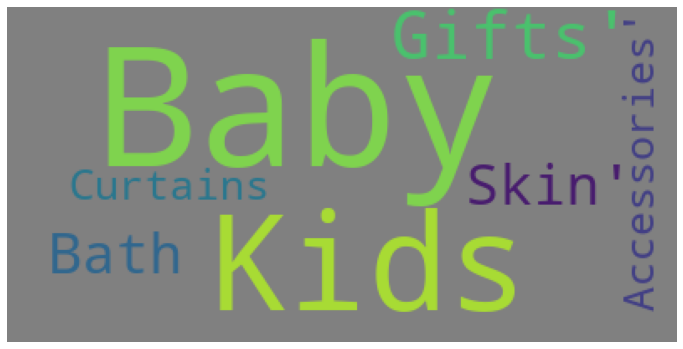

In [32]:
text = df['cat_2'].values 
wordcloud = WordCloud(background_color = "Grey").generate(str(text))

plt.figure(figsize=(12,12))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

#### <span style='color:purple'> 1.3.3. Distribution de catégorie de produit au 3e niveau </span>

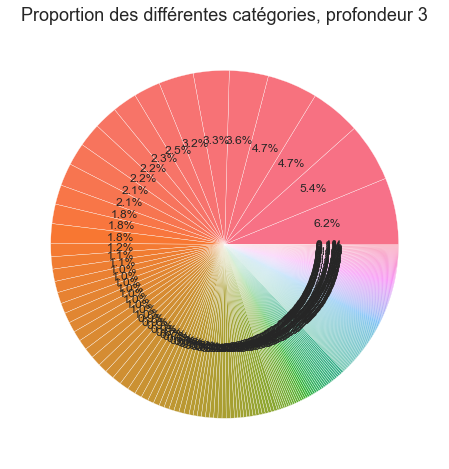

In [33]:
fig = plt.figure(1, figsize=(30, 8))
categories_3 = df["cat_3"].value_counts()

plt.title("Proportion des différentes catégories")

sns.set_palette(sns.color_palette("husl", len(categories_3)))

# Pieplot
plt.subplot(1, 2, 2)
plt.title("Proportion des différentes catégories, profondeur 3", fontsize=18)
plt.pie(categories_3, autopct='%1.1f%%')

plt.show()

In [34]:
nb_cat3 = df['cat_3'].nunique()
print('Il y a {} categories au 3e niveau.'.format(nb_cat3))

Il y a 242 categories au 3e niveau.


#### WordClouds (nuages de mots-clés) pour 3e niveau

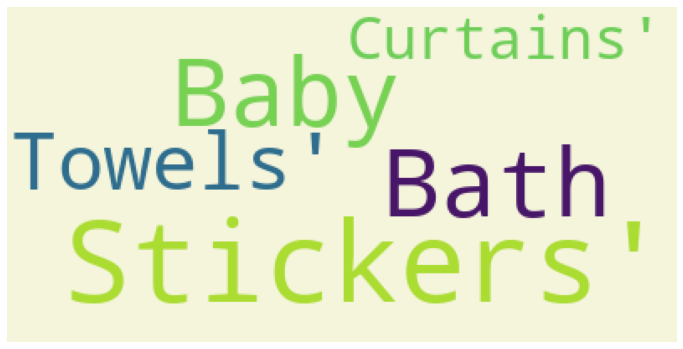

In [35]:
text = df['cat_3'].values 
wordcloud = WordCloud(background_color = "beige").generate(str(text))

plt.figure(figsize=(12,12))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

La profondeur 1 est donc choisie, car, on s'est limité à 7 clusters, et les clusters sont équilibrées (7 catégories de 150 produits). Cela nous permettra aussi de juger de la qualité de notre clustering en comparant les labels obtenus aux catégories à l'aide de l'Adjusted Rand Index.

### <span style='color:blue '>2. Données textuelles </span>

#### <span style='color:red'>2.1.Pré-Traitement du texte </span>


#### <span style='color:green'>2.1.1. Concaténation des variables textes : "product_name", "description" et "brand" </span>

In [36]:
# Assembler les "product name","description", et "brand" dans une nouvelle variable
df['description'] = df['product_name'] + ' ' + df['description'] + ' ' + df['brand']

In [37]:
# exemple
df['description'].iloc[0]

'Elegance Polyester Multicolor Abstract Eyelet Door Curtain Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant

#### <span style='color:green'>2.1.2. Agréger toutes les descriptions ensemble </span>

In [38]:
corpus = df['description'].str.cat(sep=' ')

# Obtenir la liste des mots 
list_words = corpus.split()
print("Nombre de mots: {}".format(len(list_words)))
print("Nombre de mots uniques: {}".format(len(set(list_words))))

Nombre de mots: 88668
Nombre de mots uniques: 9593


#### <span style='color:red'>2.2.Traitement du texte: Extraction de variables à partir des données textuelles  </span>

#### <span style='color:green'>2.2.1 Méthode Tf-idf </span>

Cette mesure statistique permet d'évaluer l'importance d'un terme contenu dans un document, relativement à une collection ou un corpus. Le poids augmente proportionnellement au nombre d'occurrences du mot dans le document. Il varie également en fonction de la fréquence du mot dans le corpus.

In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer

#Instanciation du vectoriseur tf-idf 
tfidf_vectorizer = TfidfVectorizer(
    strip_accents='unicode',
    lowercase=True,
    stop_words='english',
    analyzer='word',
    max_df=0.8,
    min_df=2,
    ngram_range=(1, 1),
)

# Application du vectoriseur tf-idf 
corpus = df['description']
X = tfidf_vectorizer.fit_transform(corpus)

# Conversion en une matrice dense pour une utilisation ultérieure 
X_dense = X.todense()

print('Size of the vocabulary: {}'.format(len(list(tfidf_vectorizer.vocabulary_))))
print('Number of stop words: {}'.format(len(tfidf_vectorizer.stop_words_)))

Size of the vocabulary: 2443
Number of stop words: 3399


In [40]:
import operator

# Tri de vectorizer.vocabulary_ par index de caractéristiques 
sorted_voc = sorted(tfidf_vectorizer.vocabulary_.items(), key=operator.itemgetter(1))

# Obtenir les mots de la liste triée du vocabulaire
sorted_voc = [ word for (word, word_indice) in sorted_voc ]

# Recréer pd.DataFrame avec le vocabulaire 
text_TFIDF = pd.DataFrame(X_dense, columns=sorted_voc)
text_TFIDF.columns = ['bow_' + str(col) for col in text_TFIDF.columns]

# afficher les premières lignes de la vectorisation tf-idf 
text_TFIDF.head()

bow_001  bow_005  bow_01  bow_03  bow_04  bow_05tg  bow_06  bow_085  \
0      0.0      0.0     0.0     0.0     0.0       0.0     0.0      0.0   
1      0.0      0.0     0.0     0.0     0.0       0.0     0.0      0.0   
2      0.0      0.0     0.0     0.0     0.0       0.0     0.0      0.0   
3      0.0      0.0     0.0     0.0     0.0       0.0     0.0      0.0   
4      0.0      0.0     0.0     0.0     0.0       0.0     0.0      0.0   

   bow_099    bow_10  ...   bow_yes  bow_york  bow_young  bow_youth  \
0      0.0  0.000000  ...  0.000000       0.0        0.0        0.0   
1      0.0  0.000000  ...  0.066326       0.0        0.0        0.0   
2      0.0  0.042591  ...  0.000000       0.0        0.0        0.0   
3      0.0  0.000000  ...  0.034466       0.0        0.0        0.0   
4      0.0  0.000000  ...  0.031490       0.0        0.0        0.0   

   bow_youthful  bow_yuva  bow_zero  bow_zipper  bow_zone  bow_zyxel  
0           0.0       0.0       0.0         0.0       0.0        0.0  
1           0.0       0.0       0.0         0.0       0.0        0.0  
2           0.0       0.0       0.0         0.0       0.0        0.0  
3           0.0       0.0       0.0         0.0       0.0        0.0  
4           0.0       0.0       0.0         0.0       0.0        0.0  

[5 rows x 2443 columns]



Les colonnes représentent les différents termes retenus par la méthode. Chaque ligne correspond à un descriptif produit. Les valeurs correspondent au calcul du Tf-idf précédement définis


### Visualisation via TSNE(TF-IDF)

In [41]:

def tSNE_plot(text_TFIDF, target, random_state=None):
    """Compute the tSNE. Displays the embedding on 2 dimensions."""
    
    target_name = target.name
    y = target
    
    # Applying the t-SNE
    #-------------------
    # Import libraries
    from sklearn import manifold

    # Instanciation of t-SNE
    tsne = manifold.TSNE(n_components=2, # projection in a plane
                         perplexity=30,
                         n_iter=300,
                         init='pca', # initialisation by a PCA
                         random_state=random_state
                        )

    # Applying the t-SNE
    features_projected = tsne.fit_transform(text_TFIDF) # t-SNE do not have ".transform" method

    # Plotting the t-SNE embedding
    #-----------------------------
    fig = plt.figure(figsize=(12,7))

    # Definitions of axis boundaries
    plt.xlim(features_projected[:,0].min()*1.1, features_projected[:,0].max()*1.1)
    plt.ylim(features_projected[:,1].min()*1.1, features_projected[:,1].max()*1.1)

    # Definition of axis'labels
    plt.title("t-SNE\n", fontsize=20)
    plt.xlabel("t-SNE feature 1")
    plt.ylabel("t-SNE feature 2")
    
    # For each category in the target
    for i, category in enumerate(y.unique()):
        mask = (y == category)
        features_subset = features_projected[mask]
        
        # Plotting the points of the category
        sc = plt.scatter(
            features_subset[:,0], # x-coordinate
            features_subset[:,1], # y-coordinate
            cmap=plt.cm.get_cmap('RdYlGn_r'), # colormap
            label=category
        )
    
    # Setting the legend   
    plt.legend()
    return fig

Text(0.5, 1.0, 'Visualisation via TSNE(TF-IDF)')

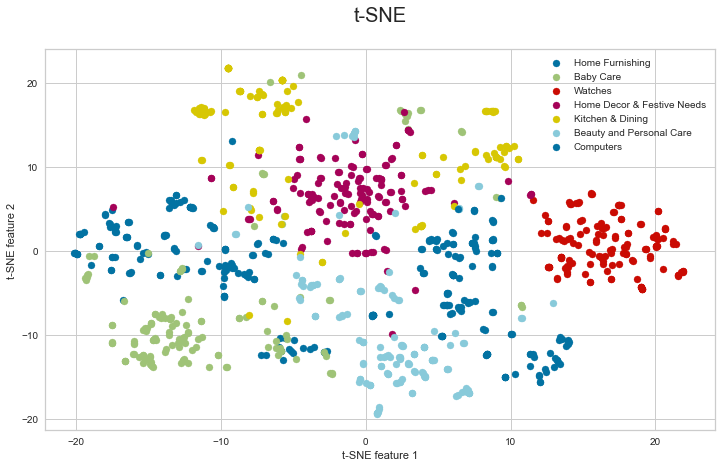

In [60]:
y = df['cat_1']
X_std = text_TFIDF

fig = tSNE_plot(X_std, y)
ax.set_title("Visualisation via TSNE(TF-IDF)", fontdict=font_title)

Le graphique montre la séparation des catégories de produis, relativement bien séparées. 

#### <span style='color:green'>2.2.2. Méthode NMF: Non-negative Matrix Factorization </span>

L'objectif de ces types de modélisation automatique de sujet, est de récupérer de potentielles catégories pour des traitements ultérieur.  Autrement dit, ces méthodes permettent de détecter les sujets latents abordés dans un corpus de documents, les assigner à ces documents. 

le lien ci-joint pour plus d'informations sur la méthodologie : https://www.math.univ-toulouse.fr/~besse/Wikistat/pdf/st-m-explo-nmf.pdf

In [43]:
from sklearn.decomposition import NMF

# Définir le nombre de sujets égal au nombre de catégories 
no_topics = 7

# Instancier NMF 
nmf = NMF(n_components=no_topics, random_state= 42, alpha=.1, l1_ratio=.5, init='nndsvd')

# Ajustement du modèle 
nmf.fit(text_TFIDF)

# Application du modèle
text_NMF = nmf.transform(text_TFIDF)

In [44]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [45]:
no_top_words = 10
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

display_topics(nmf, tfidf_feature_names, no_top_words)

Topic 0:
watch analog men women discounts india sonata great maxima boys
Topic 1:
set combo com flipkart shipping cash genuine delivery products free
Topic 2:
rockmantra mug ceramic porcelain stays thrilling crafting permanent ensuring creation
Topic 3:
baby girl boy dress details cotton fabric neck shirt sleeve
Topic 4:
cm showpiece best prices 10 handicrafts brass online 30 guarantee
Topic 5:
mug coffee ceramic mugs prithish printland tea perfect presented wardrobe
Topic 6:
laptop battery cell lapguard hp skin shapes pavilion print mouse


#### Comme on peut le voir, quelques sujets qui ont été modélisés ne sont pas interprétables. Comme Topic 0, et Certains d’autres comme topic 3, représente baby care, Topic 6, représente globalement ordinateur

In [46]:
text_NMF[0,:].sum()

0.06111237733891646

### Visualisation via TSNE(NMF)

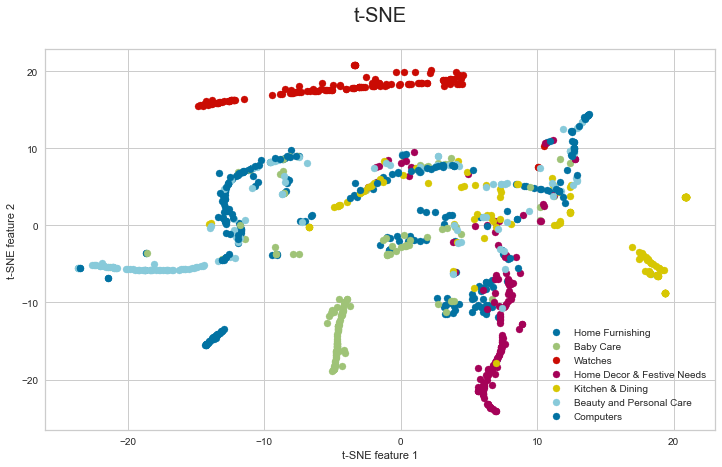

In [41]:
y = df['cat_1']
X_std = text_NMF
fig = tSNE_plot(X_std, y)

#### <span style='color:green'>2.2.3. Méthode LDA: Latent Dirichlet Allocation </span>

L’allocation de Dirichlet latente (de l'anglais Latent Dirichlet Allocation) ou LDA est un modèle génératif probabiliste permettant d'expliquer des ensembles d'observations, par le moyen de groupes non observés, eux-mêmes définis par des similarités de données.

Par exemple, si les observations (β) sont les mots collectés dans un ensemble de documents textuels (M), le modèle LDA suppose que chaque document (M) est un mélange (θ) d'un petit nombre de sujets ou thèmes (α topics), et que la génération de chaque occurrence d'un mot (w) est attribuable (probabilité) à l'un des thèmes (t) du document

Cette modélisation offre surtout une meilleure compréhension de la structuration du texte.

In [48]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Instanciation du vectoriseur tf-idf 
tf_vectorizer = CountVectorizer(
    strip_accents='unicode',
    lowercase=True,
    stop_words='english',
    analyzer='word',
    max_df=0.8,
    min_df=2,
    ngram_range=(1, 1),
)

# Application du vectoriseur tf-idf
corpus = df['description'] # TODO : fix with descriptions
tf = tf_vectorizer.fit_transform(corpus)

# Définir le nombre de sujets égal au nombre de catégories 
n_topics = 7

# Instancier LDA 
lda = LatentDirichletAllocation(n_components=n_topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0)

# Ajustement du modèle 
lda = lda.fit(tf)

# Application du modèle
text_LDA = lda.transform(tf)

In [49]:
no_top_words = 10
tf_feature_names = tf_vectorizer.get_feature_names()
display_topics(lda, tf_feature_names, no_top_words)

Topic 0:
mug ceramic coffee perfect mugs gift material rockmantra design tea
Topic 1:
products delivery free buy cash shipping genuine 30 day guarantee
Topic 2:
baby cm cotton pack features specifications general sticker color package
Topic 3:
single pizza usb quilts comforters cutter hub steel floral multicolor
Topic 4:
laptop adapter battery warranty replacement power charger quality vgn vaio
Topic 5:
skin laptop shapes print combo set mouse pad multicolor warranty
Topic 6:
cm showpiece material price box towel color features set brass


Avec la méthode LDA, Les sujets ne sont pas assez interprétables, sauf le sujet 2, qui peut présenter Baby Care

In [50]:
def plot_LDA(components):
  

    # Setting the data to plot
    labels = ['topic_{}'.format(i) for i in range(len(components))]
    frequencies = components

    # Graphical properties of the main figure
    fig = plt.figure(figsize=(14, 6))

    # Main graphical properties of the second subplot (pieplot)
    plt.title("Appartenance à des topics (LDA)", fontsize=20)

    # plotting the plots
    plt.pie(frequencies,
                autopct='%1.2f%%',
                # shadow=True,
                  )

    plt.legend(labels, loc='upper right', )
    plt.show()
    return fig

Elegance Polyester Multicolor Abstract Eyelet Door Curtain


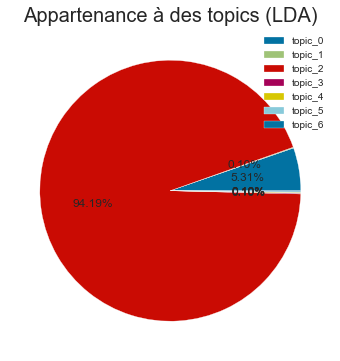

In [51]:
# Appartenance à des sujets pour le premier élément 
print(df['product_name'].iloc[0])
plot_LDA(text_LDA[0,:]);

L’Appartenance à des sujets pour le premier élément, montre majoritairement une appartenance au sujet 2 qui représente plus au moins Baby Care. 

### Visualisation via TSNE(LDA)

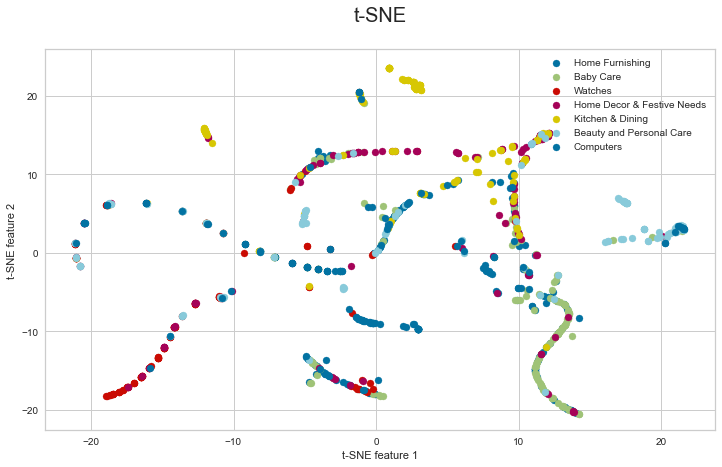

In [52]:
y = df['cat_1']
X_std = text_LDA
fig = tSNE_plot(X_std, y)

Le graphique TSNE, ne montre pas une séparation appropriée.

Donc, en résumé, la méthode Tf-idf, nous permets de mieux séparer les catégories de produits. 

### <span style='color:blue '>3.Données visuelles </span>

In [48]:
from PIL import Image, ImageFilter
from imutils import paths
from matplotlib.image import imread
from IPython.display import Image

In [49]:
from scipy.ndimage import gaussian_filter
from PIL import Image as Image_PIL

In [93]:
import cv2

#### <span style='color:red'>3.1. Visualisation: Exemples d'images</span>

Voici l'exemple d'image de chaque catégorie (profondeur 1)

Home Furnishing  :  150


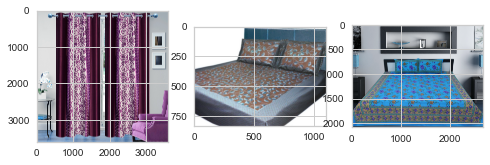

Baby Care  :  150


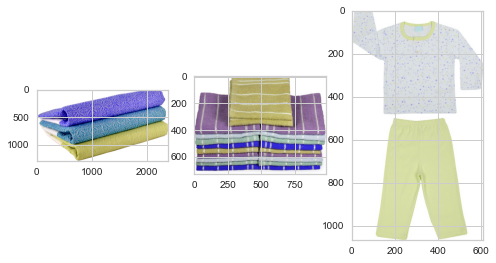

Watches  :  150


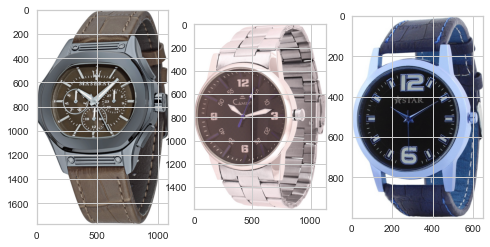

Home Decor & Festive Needs  :  150


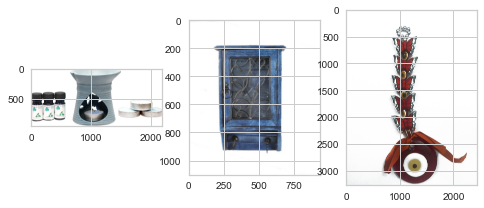

Kitchen & Dining  :  150


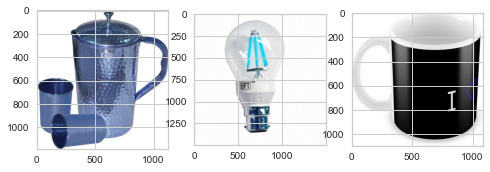

Beauty and Personal Care  :  150


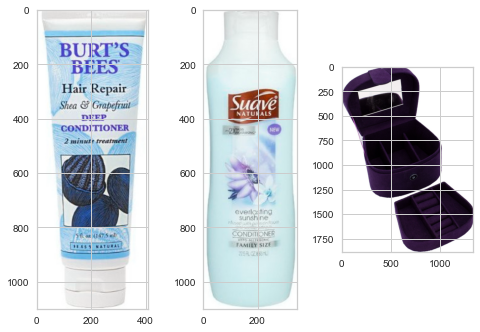

Computers  :  150


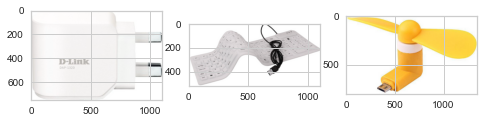

In [76]:
for cat in df['cat_1'].unique():
    images = df[df['cat_1'] == cat]
    print(cat, ' : ', len(images))
    for i in range(3):
        plt.subplot(130+1+i)
        image = cv2.imread('Images/' + images.iloc[i, :]['image'])
        plt.imshow(image)
    #plt.savefig('fig/sift_examples_'+cat+'.png', bbox_inches='tight')
    plt.show()

Regardons quelques d’autres exemples de chargement de l'image

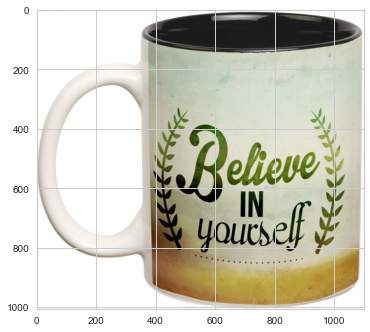

In [50]:
image1 = imread('C:/Users/sahel/OneDrive/Documents/DataScientest/Projet 6/data/Flipkart/Images/02127f52e96fb72c66bf081d25104ef8.jpg')
plt.imshow(image1)
plt.show()

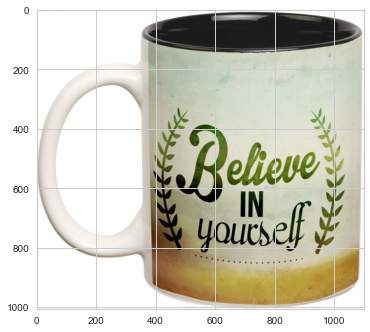

In [19]:
path = 'C:/Users/sahel/OneDrive/Documents/DataScientest/Projet 6/data/Flipkart/Images'
filename = path + '02127f52e96fb72c66bf081d25104ef8.jpg'
image1 = imread(filename)
plt.imshow(image1)

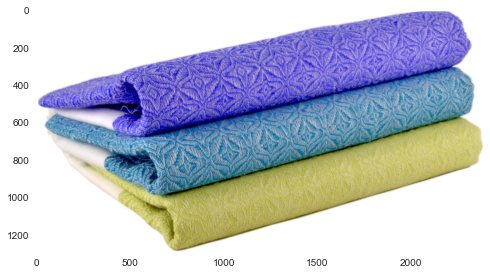

In [70]:
image_name = df['image'].loc[1]
dir_name = 'C:/Users/sahel/OneDrive/Documents/DataScientest/Projet 6/data/Flipkart/Images/'
file_path = os.path.join(dir_name, image_name)

img = cv2.imread(file_path)

# Display image
plt.imshow(img)

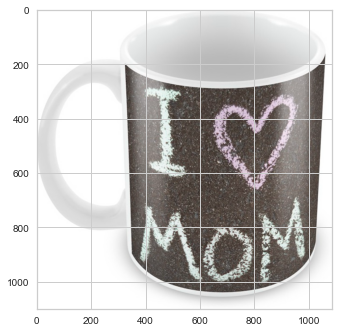

In [23]:
image_name = df['image'].loc[45]
dir_name = 'C:/Users/sahel/OneDrive/Documents/DataScientest/Projet 6/data/Flipkart/Images/'
file_path = os.path.join(dir_name, image_name)

img = cv2.imread(file_path)

# Display image
plt.imshow(img)

In [74]:
# initializations
dir_read = 'Flipkart/Images'
dir_write = 'data/preprocessed_images'

# for each product in the data
for index, row in df.iterrows():
    
    # get url of the product's image
    img_name = row['image']
    
    # create the path to the image file
    img_path = os.path.join(dir_read, img_name)
    
    # resize the image to 224*224 pixels
    img_sqr = resize_image(size=224, interpolation=cv2.INTER_AREA)
    
    # auto-adjustment of contrast and luminosity
    img_preprocessed, alpha, beta = automatic_brightness_and_contrast(img_sqr)
    
    # save the preprocessed image
    img_preprocessed_path = os.path.join(dir_write, img_name)
    cv2.imwrite(img_preprocessed_path, img_preprocessed)

In [75]:
from IPython.core.display import HTML

dir_name = '.\data\preprocessed_images'
tags = []

# Getting the list of categories of product
categories_list = list(data['cat_1'].unique())

# Iterating over categories of products
for category in categories_list:
    
    # Sampling n products belonging to the category
    mask = data['cat_1'] == category
    sample = data[mask].sample(n=15)
    
    # Iterating over each product in the sample
    
    tags.append('<br><b>{}</b><br>'.format(category))
    for index, row in sample.iterrows():
        # getting the path of image
        img_name = row['image']
        img_path = os.path.join(dir_name, img_name)
        
        # Create the html code for displaying the images
        tags.append('<img src="{}" width="50" style="display:inline"/>'.format(img_path))

tags.append('<br>')
# Display the images of the category
HTML(''.join(tags))

#### <span style='color:red'>3.2. Prétraitements des images </span>

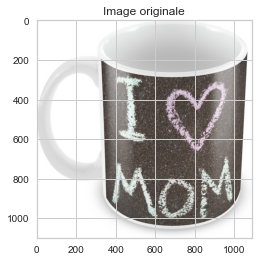

In [24]:
# Chargement d'image original
mug = cv2.imread('C:/Users/sahel/OneDrive/Documents/DataScientest/Projet 6/data/Flipkart/Images/493d1eb6ad7a48a926092bf994cd0bb0.jpg')
# Visualisation de l'image
plt.figure(figsize=(4, 4))
plt.title('Image originale')
plt.imshow(mug)
plt.show()

#### <span style='color:green'>3.2.1. Passage en gris </span>

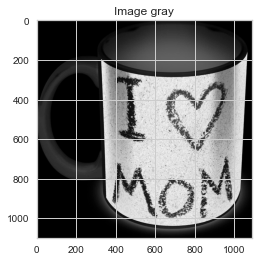

In [25]:
gray = cv2.imread('C:/Users/sahel/OneDrive/Documents/DataScientest/Projet 6/data/Flipkart/Images/493d1eb6ad7a48a926092bf994cd0bb0.jpg', cv2.IMREAD_GRAYSCALE)
plt.figure(figsize=(4, 4))
plt.title('Image gray')
plt.imshow(gray)
plt.show()

#### <span style='color:green'>3.2.2. Egalisation </span>

In [26]:
hist, bins = np.histogram(gray.flatten(), 256, [0,256])
cdf = hist.cumsum()
cdf_normalized = cdf * hist.max() / cdf.max()

/Users/saheltaherianfard/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


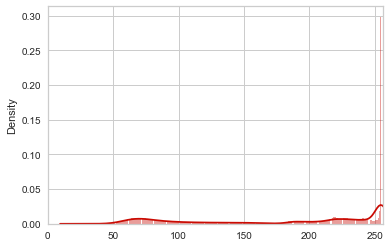

In [27]:
plt.figure(figsize=(6,4))
sns.distplot(gray.flatten(),256,[0,256], color = 'r')
plt.xlim([0,256])
plt.show()

In [28]:
cdf_m = np.ma.masked_equal(cdf,0)
cdf_m = (cdf_m - cdf_m.min())*255/(cdf_m.max()-cdf_m.min())
cdf = np.ma.filled(cdf_m,0).astype('uint8')

In [29]:
im3=cdf[gray]

/Users/saheltaherianfard/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


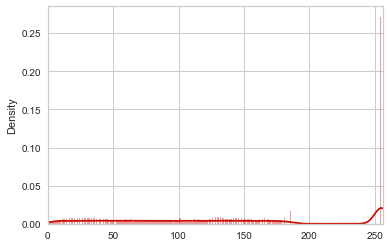

In [30]:
plt.figure(figsize=(6,4))
sns.distplot(im3.flatten(),256,[0,256], color = 'r')
plt.xlim([0,256])
plt.show()

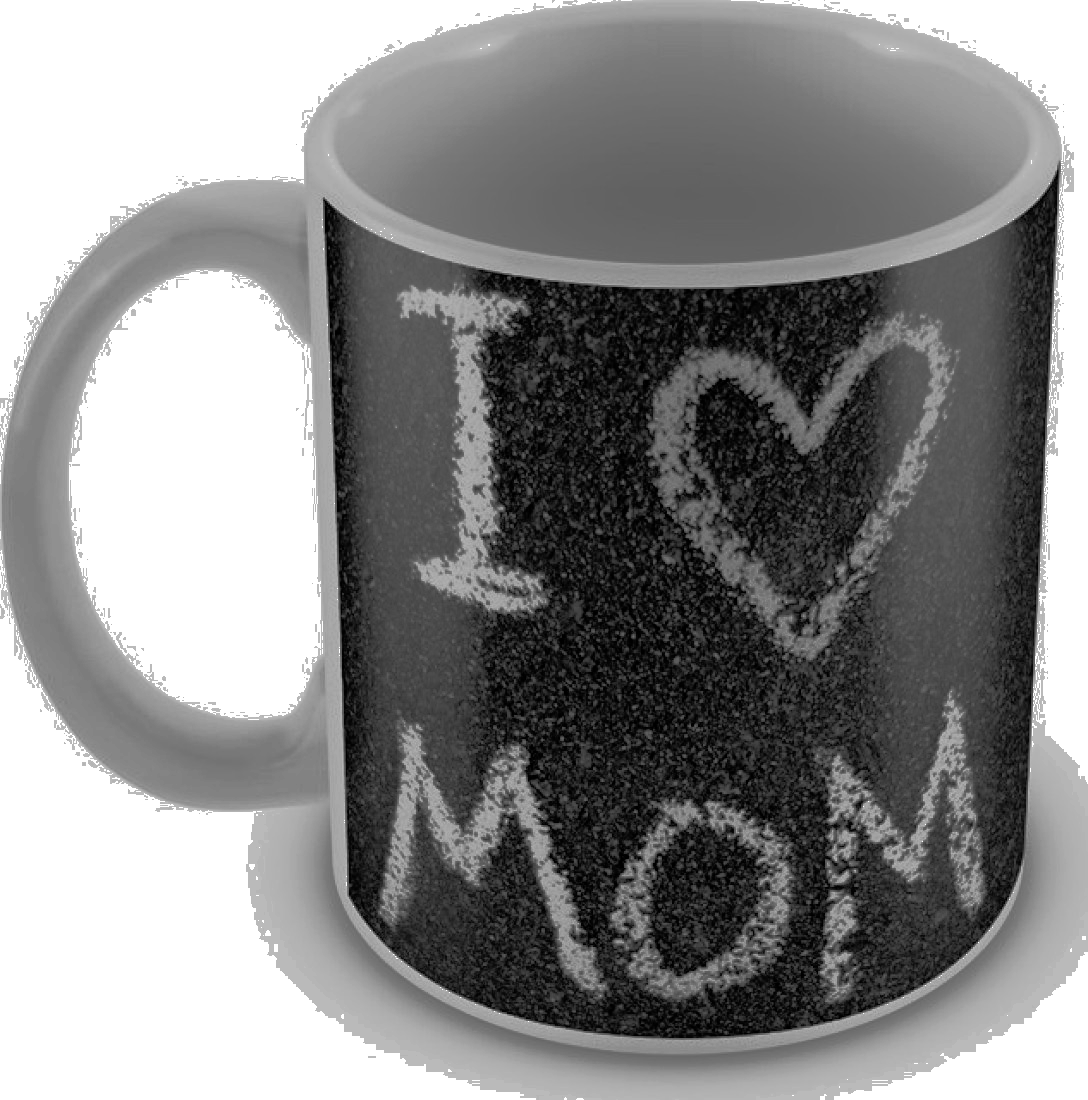

In [31]:
Image_PIL.fromarray(im3)

#### <span style='color:green'>3.2.3. Redimensionnement </span>

In [32]:
def resize_image(size, interpolation):
    """Function to resize image without deformation."""
    
    h, w = img.shape[:2]
    c = None if len(img.shape) < 3 else img.shape[2]
    
    if h == w: return cv2.resize(img, (size, size), interpolation)
    if h > w: dif = h 
    else:     dif = w
        
    x_pos = int((dif - w)/2.)
    y_pos = int((dif - h)/2.)
    
    if c is None:
        # mask = np.zeros((dif, dif), dtype=img.dtype)
        mask = np.full((dif, dif), fill_value=255, dtype=img.dtype)
        mask[y_pos:y_pos+h, x_pos:x_pos+w] = img[:h, :w]
        
    else:
        # mask = np.zeros((dif, dif, c), dtype=img.dtype)
        mask = np.full((dif, dif, c), fill_value=255, dtype=img.dtype)
        mask[y_pos:y_pos+h, x_pos:x_pos+w, :] = img[:h, :w, :]
        
    return cv2.resize(mask, (size, size), interpolation)

(224, 224, 3)


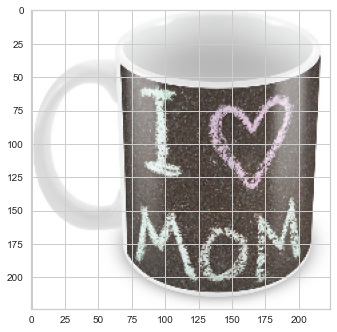

In [33]:
squared_image=resize_image(size=224, interpolation=cv2.INTER_AREA)
print(squared_image.shape)
plt.imshow(squared_image)

#### <span style='color:green'>3.2.1. Luminosité et Contraste </span>

In [34]:
# Optimisation automatique de la luminosité et du contraste avec "optional histogram clipping" 
def automatic_brightness_and_contrast(image, clip_hist_percent=1):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Calculer l'histogramme en gris 
    hist = cv2.calcHist([gray],[0],None,[256],[0,256])
    hist_size = len(hist)

    # Calculer la distribution cumulée à partir de l'histogramme 
    accumulator = []
    accumulator.append(float(hist[0]))
    for index in range(1, hist_size):
        accumulator.append(accumulator[index -1] + float(hist[index]))

    # Localiser les points à découper
    maximum = accumulator[-1]
    clip_hist_percent *= (maximum/100.0)
    clip_hist_percent /= 2.0

    # Repérez la coupe à gauche 
    minimum_gray = 0
    while accumulator[minimum_gray] < clip_hist_percent:
        minimum_gray += 1

    # Repérer la coup à droite 
    maximum_gray = hist_size -1
    while accumulator[maximum_gray] >= (maximum - clip_hist_percent):
        maximum_gray -= 1

    # Calculer les valeurs de alpha et de beta 
    alpha = 255 / (maximum_gray - minimum_gray)
    beta = -minimum_gray * alpha

    '''
    # Calculer un nouvel histogramme avec la plage souhaitée et afficher l'histogramme  
    new_hist = cv2.calcHist([gray],[0],None,[256],[minimum_gray,maximum_gray])
    plt.plot(hist)
    plt.plot(new_hist)
    plt.xlim([0,256])
    plt.show()
    '''

    auto_result = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    return (auto_result, alpha, beta)

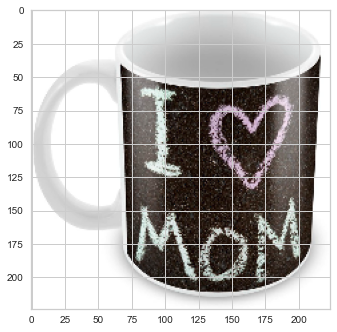

In [35]:
auto_result, alpha, beta = automatic_brightness_and_contrast(squared_image)
plt.imshow(auto_result)

#### <span style='color:red'>3.3. Traitements des images </span>

#### <span style='color:red'>Extraction de variables à partir des données visuelle </span>

#### <span style='color:green'>3.3.1. SIFT </span>


La méthodoligie d'extraction de features par SIFT se fait en 4 étapes :

    Récupérer les descripteurs de chaque image par un algorithme de type SIFT
    Clusteriser l'ensemble de tous les descripteurs
    Associer les descripteurs de chaque image aux centres obtenus par clustering
    Faire un bag of words des descripteurs de chaque image, pour toutes les images

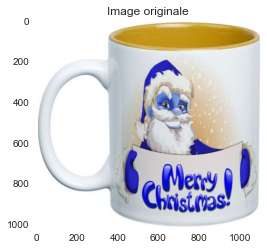

In [94]:
# Chargement de l'image
mug = cv2.imread('C:/Users/sahel/OneDrive/Documents/DataScientest/Projet 6/data/Flipkart/Images/219b24362655097cb41bf06a0be8ee79.jpg')
# Visualisation de l'image
plt.figure(figsize=(4, 4))
plt.title('Image originale')
plt.imshow(mug)
plt.show()

#### <span style='color:purple'>3.3.1.1. Extraction des caractéristiques par la méthode de SIFT</span>

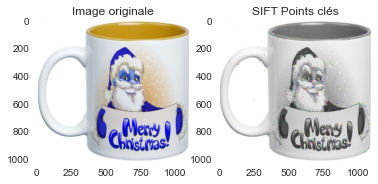

In [95]:
img = cv.imread('C:/Users/sahel/OneDrive/Documents/DataScientest/Projet 6/data/Flipkart/Images/219b24362655097cb41bf06a0be8ee79.jpg')
gray= cv.cvtColor(img,cv.COLOR_BGR2GRAY)
sift = cv.SIFT_create()
kp = sift.detect(gray,None)
img=cv.drawKeypoints(gray,kp,img)
cv.imwrite('sift_keypoints.jpg',img)

# Image originale
plt.subplot(1, 2, 1)
plt.title('Image originale')
plt.imshow(mug)


plt.subplot(1, 2, 2)
plt.imshow(img)
plt.title('SIFT Points clés')
plt.show()

La localisation des descripteurs des deux images ci-dessus est représenté par les ronds de couleur

### <span style='color:purple'>3.3.1.2. feature matching par la méthode de SIFT</span>

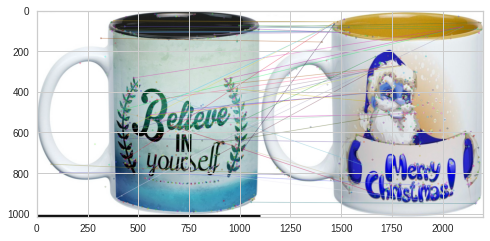

In [18]:
img1 = cv.imread('C:/Users/sahel/OneDrive/Documents/DataScientest/Projet 6/data/Flipkart/Images/02127f52e96fb72c66bf081d25104ef8.jpg')

img2 = cv.imread('C:/Users/sahel/OneDrive/Documents/DataScientest/Projet 6/data/Flipkart/Images/219b24362655097cb41bf06a0be8ee79.jpg')

# Creating SIFT feature point detection
sift = cv.xfeatures2d.SIFT_create()
# Calculate key points and feature characters
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

# BFmatcher with default parms
bf = cv.BFMatcher(cv.NORM_L2)
matches = bf.knnMatch(des1, des2, k=2) 
# Store the best matching points of feature vector matching
goodMatchs = []
for m, n in matches:
    if m.distance < 0.7 * n.distance:
        goodMatchs.append(m)
        
pic3 = cv.drawMatches(img1=img1, keypoints1=kp1, img2=img2, keypoints2=kp2, matches1to2=goodMatchs, outImg=None)
cv.imwrite('C:/Users/sahel/OneDrive/Documents/DataScientest/Projet 6/data/Flipkart/Images\compare.jpg',pic3)
plt.imshow(pic3)

Regardons un autre exemple

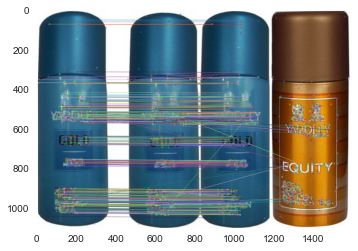

In [90]:
img1 = cv.imread('C:/Users/sahel/OneDrive/Documents/DataScientest/Projet 6/data/Flipkart/Images/fa6f5eb34be4ad5daec225bfe09f2414.jpg')

img2 = cv.imread('C:/Users/sahel/OneDrive/Documents/DataScientest/Projet 6/data/Flipkart/Images/f74e1afad2c545c25ee38193d0eb87d5.jpg')

# Creating SIFT feature point detection
sift = cv.xfeatures2d.SIFT_create()
# Calculate key points and feature characters
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

# BFmatcher with default parms
bf = cv.BFMatcher(cv.NORM_L2)
matches = bf.knnMatch(des1, des2, k=2) 
# Store the best matching points of feature vector matching
goodMatchs = []
for m, n in matches:
    if m.distance < 0.7 * n.distance:
        goodMatchs.append(m)
        
pic3 = cv.drawMatches(img1=img1, keypoints1=kp1, img2=img2, keypoints2=kp2, matches1to2=goodMatchs, outImg=None)
cv.imwrite('C:/Users/sahel/OneDrive/Documents/DataScientest/Projet 6/data/Flipkart/Images\compare.jpg',pic3)
plt.imshow(pic3)

### <span style='color:purple'>3.3.1.3. Construction des features</span>
### <span style='color:purple'>BOW SIFT (Sac de mots visuels)</span>

Bag of visual words (BOW) est couramment utilisé dans la classification des images. Son concept est adapté du sac de mots de la NLP. 

In [4]:
# Extraction des descripteurs SIFT et les ajouter dans un objet BOW
clusterCount=100
BOW  = cv.BOWKMeansTrainer(clusterCount=clusterCount)
sift = cv.SIFT_create()

for i in range(len(df.image)):
    file_name = df.image[i]
    img = cv.imread(file_name, cv.IMREAD_GRAYSCALE)
    kp, des = sift.detectAndCompute(img,None)
    if des is not None:
        BOW.add(des)

In [5]:
# Création du vocabulaire avec KMeans à partir de tous les descripteurs
vocabulary = BOW.cluster()

#### On crée un objet qui extrait les descripteurs SIFT, et qui affecte chaque descripteur à l'élément du vocabulaire qui lui corresponde et qui crée un histogramme de présence de chaque mot du vocabulaire dans l'image

In [6]:
sift2 = cv.SIFT_create()
bowDiction = cv.BOWImgDescriptorExtractor(sift2, cv.BFMatcher(cv.NORM_L2))
bowDiction.setVocabulary(vocabulary)

# appliquer bowDiction sur les images du dataset
def extract_SIFT_BOW(file_name):
    img = cv.imread(file_name, cv.IMREAD_GRAYSCALE)
    return bowDiction.compute(img, sift.detect(img))

df['SIFT_BOW'] = df.image.apply(lambda x: extract_SIFT_BOW(x))

In [7]:
df.SIFT_BOW.at[343] = np.array([0]*clusterCount).reshape(1, clusterCount).astype('float32')

### <span style='color:purple'>3.3.1.4. Réduction de dimensions avec un PCA sur SIFT BOW</span>

In [16]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

In [17]:
def reshape_array(arr):
    return arr.reshape(clusterCount)
df['SIFT_BOW'] = df.SIFT_BOW.apply(lambda x: reshape_array(x))

In [18]:
scaler = MinMaxScaler()
scaled_bow = scaler.fit_transform(np.asarray([list(arr) for arr in list(df.SIFT_BOW)]))

In [19]:
pca_on_bow = PCA(n_components=2).fit_transform(scaled_bow)

In [20]:
df['PCA_on_SIFT_BOW'] = list(pca_on_bow)

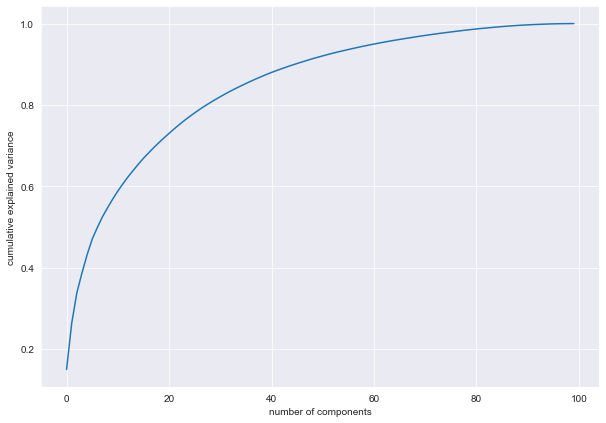

In [21]:
fig, ax = plt.subplots(figsize=(10, 7))
pca = PCA().fit(scaled_bow)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
#plt.xticks(range(0, 1050, 5))
plt.grid()

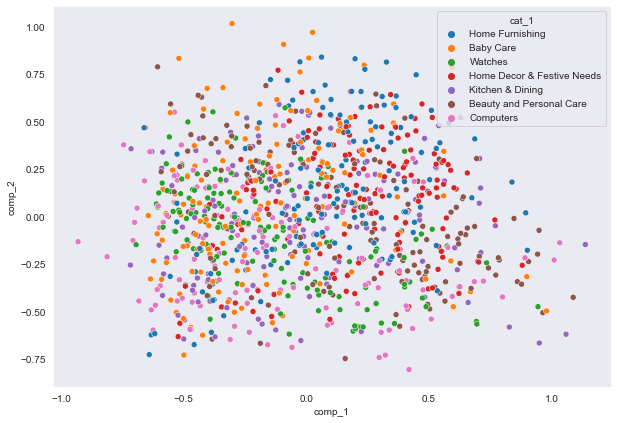

In [63]:
fig, ax = plt.subplots(figsize=(10, 7))
viz_df = pd.DataFrame()
viz_df['comp_1'] = pca_on_bow[:, 0]
viz_df['comp_2'] = pca_on_bow[:, 1]
viz_df['cat_1'] = list(df.cat_1)
sns.scatterplot(x='comp_1', y='comp_2', hue='cat_1', data=viz_df)
plt.show()
del(viz_df)

Ce graphique représente une projection 2D par un PCA sur SIFT BOW. La séparation de catégories des produits n'est pas bien faite.

### <span style='color:purple'>3.3.1.5. Réduction de dimensions avec un TSNE sur SIFT BOW</span>

In [70]:
from sklearn.manifold import TSNE

In [71]:
tsne_on_bow = TSNE(n_components=2).fit_transform(list(df['SIFT_BOW']))

In [72]:
df['TSNE_on_BOW'] = list(tsne_on_bow)

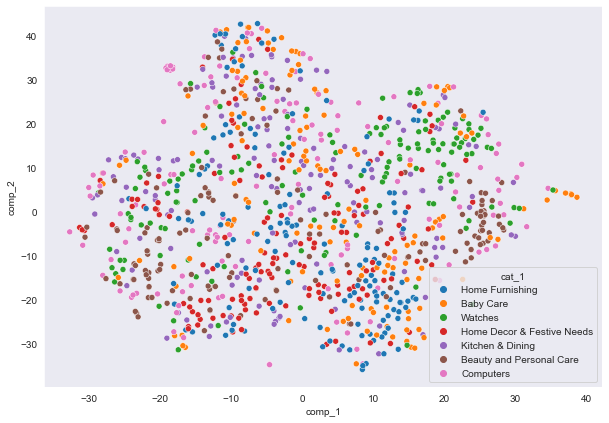

In [73]:
fig, ax = plt.subplots(figsize=(10, 7))
viz_df = pd.DataFrame()
viz_df['comp_1'] = tsne_on_bow[:, 0]
viz_df['comp_2'] = tsne_on_bow[:, 1]
viz_df['cat_1'] = list(df.cat_1)
sns.scatterplot(x='comp_1', y='comp_2', hue='cat_1', data=viz_df)
plt.show()
del(viz_df)

Ce graphique représente une projection 2D par un TSNE sur SIFT BOW. La séparation de catégories des produits n'est pas bien faite. 

#### <span style='color:green'>3.3.2. Transfert Learning </span>

Dans cette partie, nous utilisons ce réseau pré-entrainé en extrayant le résultat de la dernière couche appliqué à nos données. A cette dernière couche, est appliqué un algorithme de réduction de dimensions. Ensuite, on peut utiliser la méthode k-means pour définir des clusters correspondant aux catégories d'images présentes dans notre jeu de données.

In [12]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import VGG16
from keras.models import Model

In [13]:
# Charger VGG-16 pré-entraîné sur ImageNet 
model = VGG16(weights='imagenet')
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

553476096/553467096 [==============================] - 42s 0us/step


Nous devons d'abord charger l'image et la pré-traiter afin qu'elle respecte bien les spécifications des images en entrée de VGG-16. Pour cela, nous allons utiliser les fonctions du module  keras.preprocessing.image  et  keras.preprocessing.vgg16
- Redimensionner en (224, 224, 3), fonction : load_image
- Transformer en tableaux numpy :  img_to_array
- Une collection d'images, stockée dans un tableau de 4 dimensions: numpy.reshape
- Appliquer les mêmes pré-traitements que ceux utilisés sur l'ensemble d'apprentissage lors du pré-entraînement: preprocess_input

In [14]:
def extract_VGG_features(file_name):
    image = load_img(file_name, target_size=(224, 224)) # Charger l'image
    image = img_to_array(image)  # Convertir en tableau numpy
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2])) # Créer la collection d'images (un seul échantillon)
    image = preprocess_input(image)   # Prétraiter l'image comme le veut VGG-16
    return model.predict(image)   # Prédir la classe de l'image (parmi les 1000 classes d'ImageNet)

df['VGG_features'] = df.image.apply(lambda x: extract_VGG_features(x))

C:\Users\sahel\anaconda3\lib\site-packages\PIL\Image.py:2855: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [15]:
df.VGG_features.iloc[0].shape

(1, 4096)

Les deux premières couches fully-connected calculent chacune un vecteur de taille 4096,

### <span style='color:purple'>3.3.2.1. Réduction de dimensions avec un PCA sur transfer learning features</span>

In [64]:
def reshape_array(arr):
    new_shape = arr.shape[1]
    return arr.reshape(new_shape)
df['VGG_features'] = df.VGG_features.apply(lambda x: reshape_array(x))

In [65]:
scaler = MinMaxScaler()
scaled_vgg_features = scaler.fit_transform(np.asarray([list(arr) for arr in list(df.VGG_features)]))

In [66]:
pca_on_vgg_features = PCA(n_components=2).fit_transform(scaled_vgg_features)

In [67]:
df['PCA_on_VGG_features'] = list(pca_on_vgg_features)

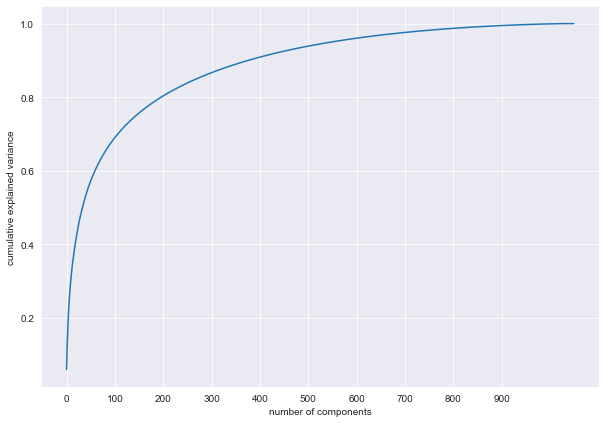

In [68]:
fig, ax = plt.subplots(figsize=(10, 7))
pca = PCA().fit(scaled_vgg_features)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.xticks(range(0, 1000, 100))
plt.grid()

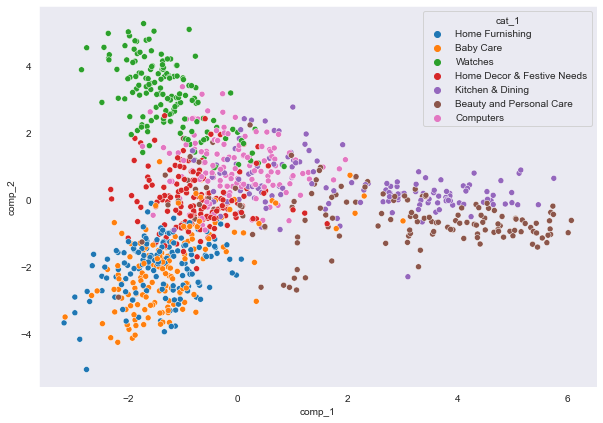

In [69]:
fig, ax = plt.subplots(figsize=(10, 7))
viz_df = pd.DataFrame()
viz_df['comp_1'] = pca_on_vgg_features[:, 0]
viz_df['comp_2'] = pca_on_vgg_features[:, 1]
viz_df['cat_1'] = list(df.cat_1)
sns.scatterplot(x='comp_1', y='comp_2', hue='cat_1', data=viz_df)
plt.show()
del(viz_df)

Ce graphique représente une projection 2D par PCA des features de VGG. Il illustre la possibilité d'une classification. On peut voir par visualisation PCA que certaines catégories sont bien identifiées mais les zones moins denses sont moins bien séparées.

### <span style='color:purple'>3.3.2.2. Réduction de dimensions avec un TSNE sur transfer learning features</span>

In [74]:
tsne_on_vgg_features = TSNE(n_components=2).fit_transform(list(df['VGG_features']))

In [75]:
df['TSNE_on_VGG_features'] = list(tsne_on_vgg_features)

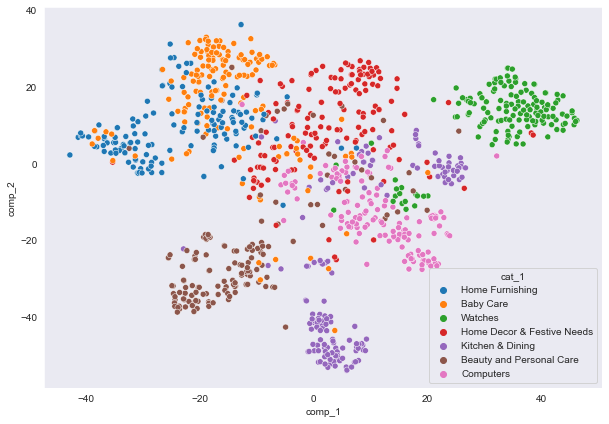

In [76]:
fig, ax = plt.subplots(figsize=(10, 7))
viz_df = pd.DataFrame()
viz_df['comp_1'] = tsne_on_vgg_features[:, 0]
viz_df['comp_2'] = tsne_on_vgg_features[:, 1]
viz_df['cat_1'] = list(df.cat_1)
sns.scatterplot(x='comp_1', y='comp_2', hue='cat_1', data=viz_df)
plt.show()
del(viz_df)

Ce graphique représente une projection 2D par TSNE des features de VGG. Il illustre la possibilité d'une classification, puisqu'il apparait une séparation visuelle franche des différentes catégories de produits. Notre TSNE, sépare mieux les catégories de produit par rapport notre PCA

#### <span style='color:green'>3.3.3. Clustering sur des features réduites de VGG </span>

In [77]:
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics import confusion_matrix

### <span style='color:purple'>3.3.3.1. Utilisation des features réduits par le PCA</span>

In [78]:
y_preds = KMeans(n_clusters=7).fit_predict(list(df['PCA_on_VGG_features']))

In [79]:
df['predicted_cat_PCA_on_VGG_features'] = list(y_preds)

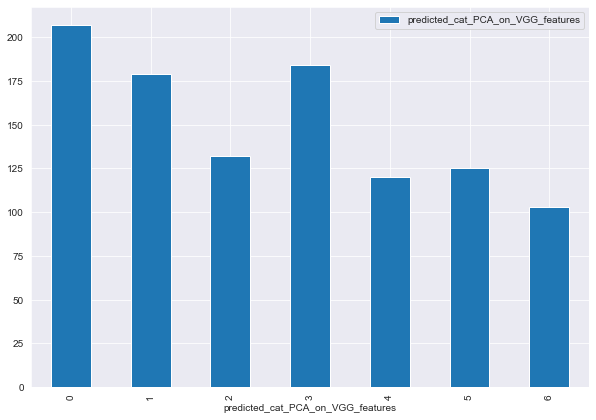

In [80]:
ax = df.groupby(by='predicted_cat_PCA_on_VGG_features').agg({'predicted_cat_PCA_on_VGG_features': 'count'}).plot.bar(figsize=(10, 7))
plt.grid()

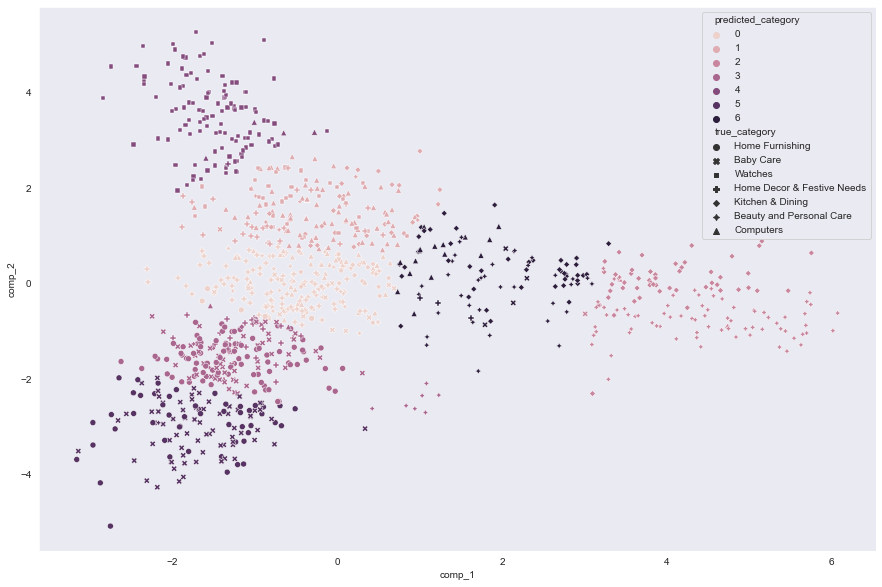

In [81]:
# visualiser les produits avec leurs catégories prévues
comp_1 = list(np.array(list(df.PCA_on_VGG_features))[:, 0])
comp_2 = list(np.array(list(df.PCA_on_VGG_features))[:, 1])
df_viz = pd.DataFrame()
df_viz['comp_1'] = comp_1
df_viz['comp_2'] = comp_2
df_viz['predicted_category'] = y_preds
df_viz['true_category'] = list(df.cat_1)
fig, ax = plt.subplots(figsize=(15, 10))
sns.scatterplot(x='comp_1', y='comp_2', hue='predicted_category', style='true_category', data=df_viz, )
plt.show()

### <span style='color:purple'>3.3.3.2. Matrice de Confusion</span>

Les labels sont encodés numériquement

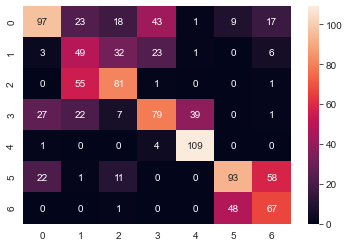

In [ ]:
translate_dict = {1: 'Home Decor & Festive Needs ', 
                  6: 'Kitchen & Dining ', 
                  0: 'Beauty and Personal Care ', 
                  5: 'Computers ', 
                  3: 'Watches ', 
                  4: 'Home Furnishing ', 
                  2: 'Baby Care '}
def translate_predicted_category(p_category_number):
    return translate_dict[p_category_number]

d=pd.DataFrame(confusion_matrix(y_true=df.first_level_category, 
                 y_pred=df.predicted_cat_PCA_on_VGG_features.apply(translate_predicted_category), 
                 labels=list(translate_dict.values())
                ).T)
sns.heatmap(d, annot=True, fmt='d')

In [ ]:
# score ARI
adjusted_rand_score(list(df.first_level_category), list(y_preds))

0.3043218035174003

### <span style='color:purple'>3.3.3.3. Utilisation des features réduits par le TSNE</span>

In [84]:
y_preds = KMeans(n_clusters=7).fit_predict(list(df['TSNE_on_VGG_features']))

In [85]:
df['predicted_cat_TSNE_on_VGG_features'] = list(y_preds)

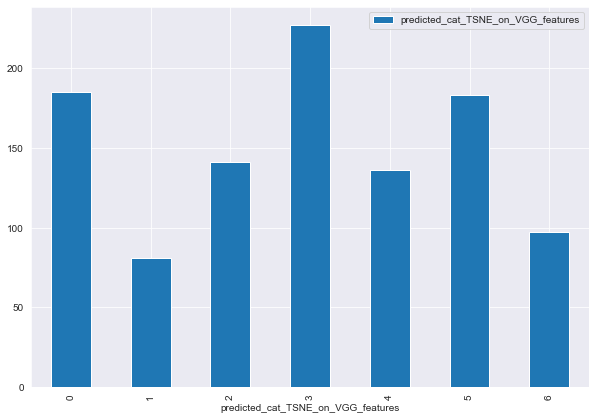

In [86]:
ax = df.groupby(by='predicted_cat_TSNE_on_VGG_features').agg({'predicted_cat_TSNE_on_VGG_features': 'count'}).plot.bar(figsize=(10, 7))
plt.grid()

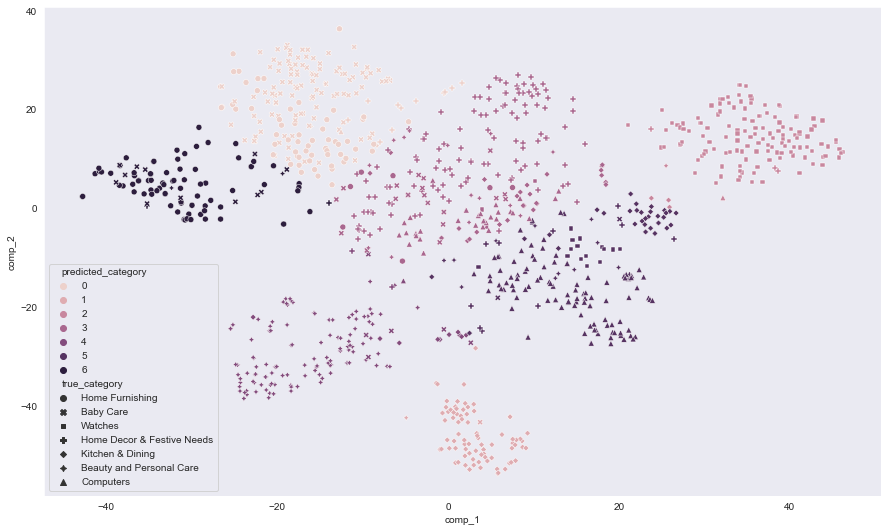

In [87]:
# visualiser les produits avec leurs catégories prévues
comp_1 = list(np.array(list(df.TSNE_on_VGG_features))[:, 0])
comp_2 = list(np.array(list(df.TSNE_on_VGG_features))[:, 1])
df_viz = pd.DataFrame()
df_viz['comp_1'] = comp_1
df_viz['comp_2'] = comp_2
df_viz['predicted_category'] = y_preds
df_viz['true_category'] = list(df.cat_1)
fig, ax = plt.subplots(figsize=(15, 9))
sns.scatterplot(x='comp_1', y='comp_2', hue='predicted_category', style='true_category', data=df_viz, )
plt.show()

### <span style='color:purple'>3.3.3.4. Matrice de Confusion</span>

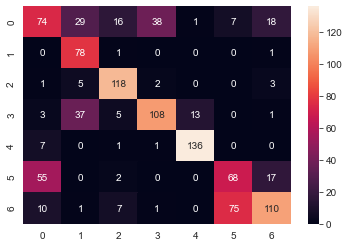

In [ ]:
translate_dict = {3: 'Home Decor & Festive Needs ', 
                  2: 'Kitchen & Dining ', 
                  5: 'Beauty and Personal Care ', 
                  4: 'Computers ', 
                  1: 'Watches ', 
                  6: 'Home Furnishing ', 
                  0: 'Baby Care '}
def translate_predicted_category(p_category_number):
    return translate_dict[p_category_number]

d=pd.DataFrame(confusion_matrix(y_true=df.first_level_category, 
                 y_pred=df.predicted_cat_TSNE_on_VGG_features.apply(translate_predicted_category), 
                 labels=list(translate_dict.values())
                ).T)
sns.heatmap(d, annot=True, fmt='d')

In [ ]:
# score ARI
adjusted_rand_score(list(df.first_level_category), list(y_preds))

0.44578640295537836

Ce score n'est pas mauvais, la méthode est donc exploitable.

In [ ]:
os.chdir(r'C:\Users\sahel\OneDrive\Documents\DataScientest\Projet 6\data\Flipkart')
np.save('image_features.npy', np.array(df.TSNE_on_VGG_features), allow_pickle=True)
np.save('cat_1.npy', np.array(df.cat_1), allow_pickle=True)